# 第9章 SHAPのテーブルデータへの活用

## 説明のための準備
### 環境構築

In [1]:
from pprint import pprint
import pandas as pd
import sklearn
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use("ggplot")
sns.set(font="meiryo")

### データセット準備

In [2]:
# Prediction task is to determine whether a person makes over 50K a year.
X,y = shap.datasets.adult()
# 説明変数
display(X.head())
# 目的変数
print(y[:10])
# データサイズ
print(X.shape)
# 各列のデータ型
print(X.dtypes)
# 各列の欠損数: 欠損はないので今回は前処理の必要はない
print(X.isna().sum())

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


[False False False False False False False  True  True  True]
(32561, 12)
Age               float32
Workclass            int8
Education-Num     float32
Marital Status       int8
Occupation           int8
Relationship        int32
Race                 int8
Sex                  int8
Capital Gain      float32
Capital Loss      float32
Hours per week    float32
Country              int8
dtype: object
Age               0
Workclass         0
Education-Num     0
Marital Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours per week    0
Country           0
dtype: int64


- "Workclass"や"Marital Status"などのデータ型を明示的にカテゴリ型に指定しておきます。

In [3]:
for c in X.columns:
    if X[c].dtype==np.int8:
        # データ型を変更
        X[c] = X[c].astype("category")
print(X.dtypes)

Age                float32
Workclass         category
Education-Num      float32
Marital Status    category
Occupation        category
Relationship         int32
Race              category
Sex               category
Capital Gain       float32
Capital Loss       float32
Hours per week     float32
Country           category
dtype: object


- 説明変数および目的変数を、学習用とテスト用にそれぞれランダムに分割しておきます。

In [4]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,random_state=0)

### モデル準備

### LightGBMモデルの学習と評価

- LGBMClassifier
- 予測値(確率)の評価指標: AUC-ROCスコアおよび混同行列

In [5]:
# モデル学習: 
model = lgb.LGBMClassifier()
model.fit(X_train.values, y_train)
# 予測値の算出: 
# predict_probの返り値は(0の確率, 1の確率)の2列からなるので、1の確率のみを取り出しておく
y_pred_prob = model.predict_proba(X_test)[:, 1] 
y_pred = model.predict(X_test)
# 予測値の評価: 
val = sklearn.metrics.roc_auc_score(y_test, y_pred_prob)
print(f"auc-rocスコア: {val}")
display(pd.crosstab(y_test, y_pred))

auc-rocスコア: 0.9259691747566055


col_0,False,True
row_0,,
False,5757,402
True,675,1307


- チューニングを行わないので、モデルパラメータはデフォルト値のまま

In [6]:
pprint(model.get_params())

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


## SHAPの適用
1. SHAP値の算出と理解  
2. SHAP値の可視化  
3. SHAP値のさらなる分析  

### SHAP値の算出と理解
- TreeSHAP\[tree\]

In [7]:
# 説明器の準備～SHAP値算出
exp = shap.TreeExplainer(model)
sv_test = exp.shap_values(X_test)
sv_test = sv_test[1]
# もとのデータセットと同じサイズの行列が得られる
print(X_test.shape, sv_test.shape)
print(sv_test[0])

(8141, 12) (8141, 12)
[-0.13931476 -0.00918824 -0.03543026  0.23280898 -0.21130445 -1.15300361
  0.0103698  -0.48692901 -0.23234593 -0.04468468  0.45903885  0.00859665]


```
expected_value[1] + (SHAP値の総和) = 予測確率
```
が成り立つはず
- SHAP値を足し合わせてモデルの予測値と比較

In [8]:
print(exp.expected_value[1] + sv_test[0].sum(), y_pred_prob[0])

-3.999128895539175 0.018001602486371077


- 計算結果: 両者は一致しない  
⇒全ての予測対象について(SHAP値の足し合わせ, 予測値)を計算してプロット 

Text(0, 0.5, 'モデルの予測確率')

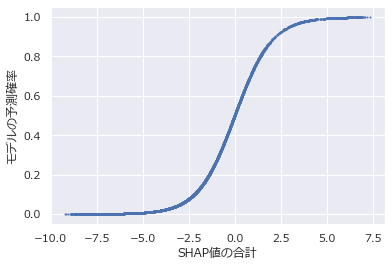

In [9]:
# SHAP値の合計 + 平均値
sv_sum = sv_test.sum(axis=1) + exp.expected_value[1]
plt.scatter(sv_sum, y_pred_prob, s=1)
plt.xlabel("SHAP値の合計")
plt.ylabel("モデルの予測確率")


$$y = \frac{1}{1 + \mathrm{exp}(-x)}$$

で表されるシグモイド関数のグラフになっている  
⇒SHAP値から元のモデルの確率の予測値を復元する場合、SHAP値の総和にシグモイド関数を適用 

In [10]:
prob_shap = (1/(1+np.exp(-sv_sum))) # SHAP値から復元したモデルの予測確率
assert np.all(np.isclose(prob_shap, y_pred_prob))

#### SHAP値に関するまとめ
```
モデル -> 予測値(実数値オッズ) -> (シグモイド関数) -> 予測値(0-1確率)
           v (平均値を差し引く)
        正規化したオッズ      -> (影響度計算) ->  SHAP値
```

### コラム: LightGBMのSHAP連携機能

- LightGBMによるSHAP値の計算

In [11]:
pred = model.predict_proba(X_test)[:,1] # 元の予測確率
res = model.predict(X_test, pred_contrib=True) # SHAP値行列を復元
# TODO: SHAPライブラリから求めた値との比較
pred2 = (1/(1+np.exp(-(res[:,:-1].sum(axis=1) + res[:,-1])))) # 予測確率を復元 
assert np.all(np.isclose(pred,pred2))

## SHAP値のプロットによるモデル理解

### 個別の予測に対する特徴量の影響

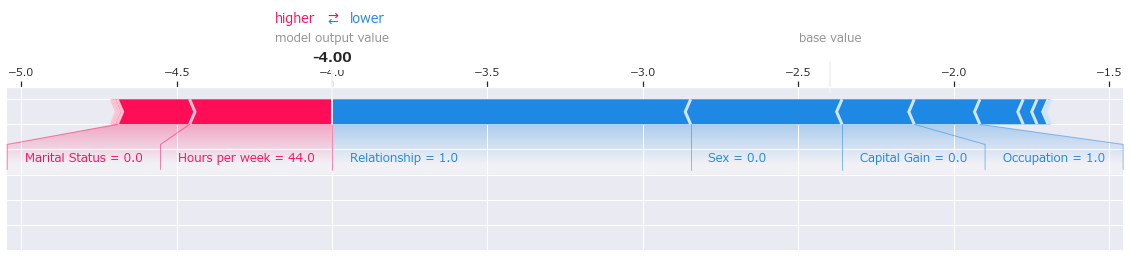

In [12]:
# shap.initjs() # javascriptを使うために必要. javescript環境がない場合はmatplotlib引数をTrueにして与える
shap.force_plot(exp.expected_value[1], sv_test[0], X_test.iloc[0], matplotlib=True)

#### force_plot  
Relationship, Hours per weekといった特徴量の影響が大きく、それらはマイナスの方向に効いている  

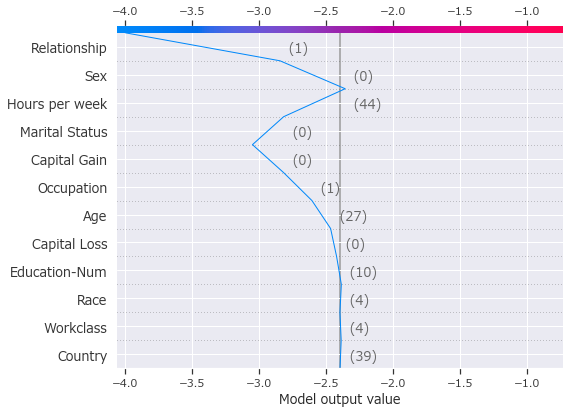

In [13]:
# decision_plot: 特徴量の数が多い場合に
shap.decision_plot(exp.expected_value[1], sv_test[0], X_test.iloc[0])

#### decision_plot  
⇒半数程度の特徴量はほぼ影響していない 

### データセット全体に対する特徴量の効き方 

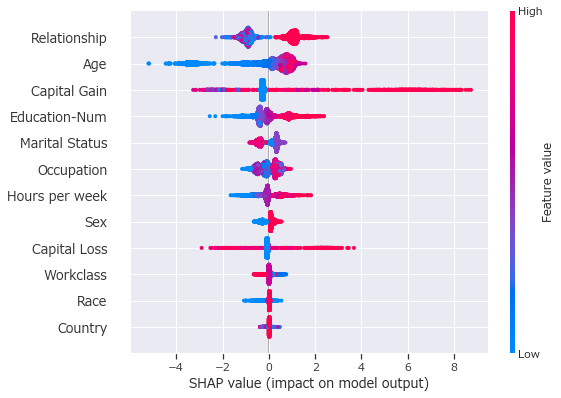

In [14]:
shap.summary_plot(sv_test, X_test)

#### summary_plot
* おおまかに年齢が低いとマイナス方向に、高いとプラス方向に効いている
* 年齢が高い場合のプラス方向の効き方よりも、年齢が低い場合のマイナス方向の効き方のほうが大きい
* 多くの場合効き方の絶対値は小さく、大きな寄与をするのは一部ケースに限られる 

#### 特徴量の重要度のみを知りたい場合

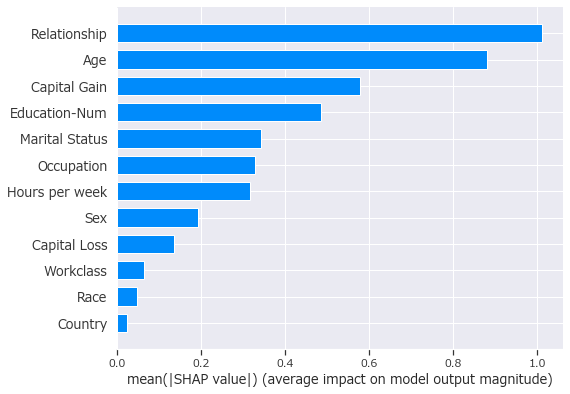

In [15]:
shap.summary_plot(sv_test, X_test, plot_type="bar")

### SHAP値と特徴量の相関の可視化 

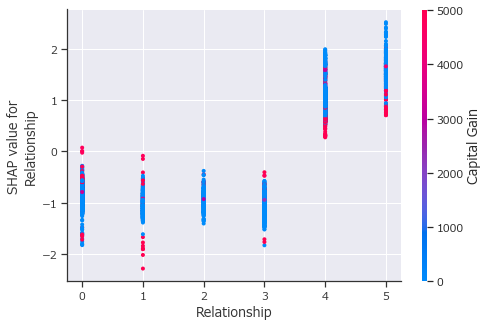

In [16]:
shap.dependence_plot("Relationship", sv_test, X_test)

#### dependence_plot
* 値が4,5の場合にプラス、それ以外はマイナス方向の寄与をとる傾向
* Relationshipの値が4,5かつCapital Gainの値が大きい場合にマイナス方向の交互作用が存在する

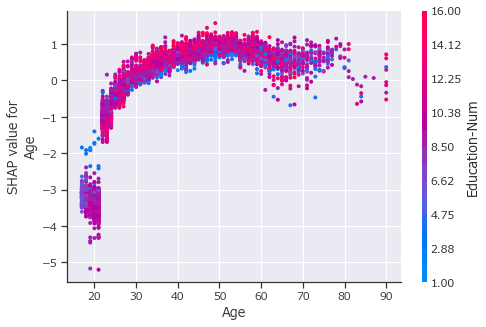

In [17]:
shap.dependence_plot("Age", sv_test, X_test)

#### dependence_plot
* 年齢が低い場合は全体的に予測値は低くなるが、例外的にあまり低く効いていないケースがあり、そのような場合は教育水準が高くない
* 年齢が一定以上の場合は年齢は概ね同じようにプラス方向に影響するが、教育水準が高い場合により大きくなり、低い場合には小さくなる(交互作用がある)
* 年齢が60歳以上のケースで縦方向のばらつき、特に、予測値が低くなるケースがあるがこの要因はこの図だけでは読み取れない(Education-num以外の特徴量との交互作用があると思われる)

### コラム: 変数間の相互作用をより細かく観察する方法: SHAP Interaction Values
#### Interaction Values
* 2つの特徴量の交互作用のみを取り出して算出する
* 1つの特徴量に対し、全体の効果から他の変数との交互作用を差し引いて、単独の影響のみを算出する

In [19]:
iv = exp.shap_interaction_values(X_test) # interaction valueの算出
print(iv.shape) # (データ数, 特徴量数, 特徴量数)のサイズ
assert np.all(np.isclose(sv_test[:,0], iv[:,0,:].sum(axis=1))) # 特徴量について足し合わせるとSHAP値に一致する

(8141, 12, 12)


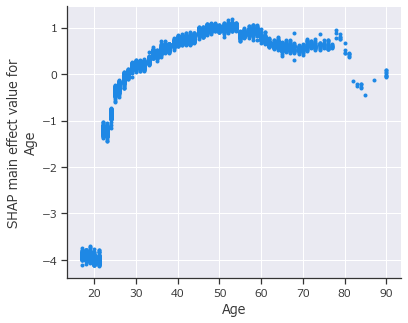

In [20]:
# "Age"の影響(SHAP値)からそれ以外の特徴量の交互作用を除いたプロット
# 縦方向のばらつきが小さくなっている
shap.dependence_plot(
    ("Age", "Age"),
    iv, X_test,
    display_features=X_test
)

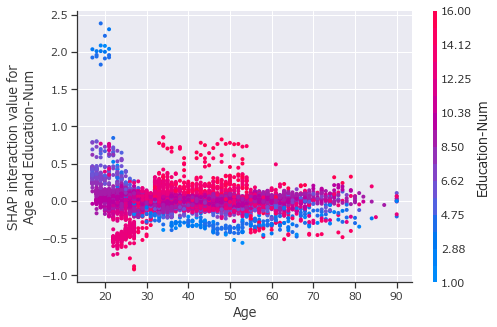

In [21]:
# "Age"と"Education-Num"の交互作用のプロット
#  dependence_plotと同じ傾向の交互作用が確認できる
shap.dependence_plot(
    ("Age", "Education-Num"),
    iv, X_test,
    display_features=X_test
)